In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib
np.random.seed(1)
torch.manual_seed(1)

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

# 定义损失函数
def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx + torch.pi * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 32
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 300

solver_list = []

# 初始化：迭代过程中使用的数据
pde_input_list = [None for i in range(T_iter)]
pde_output_list = [None for i in range(T_iter)]
bc_input_list = [None for i in range(T_iter)]
bc_output_list = [None for i in range(T_iter)]
last_flame_data_list = [None for i in range(T_iter)]
 
# INIT:BEGIN
# aim1:pde_input_list,pde_output_list,bc_input_list 不会因train改变，在本段中生成
# aim2:网络建立
# bc_output_list 在train时生成
for T_id in range(T_iter):
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 + 0.2

    pde_input_list[T_id] = \
        D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output_list[T_id] = np.zeros([pde_epoch_size,1])
    bc_input_list[T_id] = np.array([[t_span_start]])

    solver_list.append(CloudPointSolver(
        model = [1, 100, 100, 100, 1],
        optimizer = "adam"))
# INIT:END

# TRAIN:BEGIN
epoch_num = T_iter * epoch_per_iter
for T_id in range(T_iter):
    print(f'current start:{T_id}')
    for i in range(epoch_per_iter):
        for use_model_id in range(T_iter):
            t_span_start = 2*use_model_id
            t_span_end = 2*use_model_id+2 +0.2
            # 模型信息交换周期
            if i%10 == 0:
                last_flame_data_list[use_model_id] = \
                    np.array(solver_list[use_model_id].model_eval([[t_span_start + 2]]))
                if use_model_id == 0:
                    bc_output_list[use_model_id] = np.zeros([bc_epoch_size ,1]) + 1
                else:
                    bc_output_list[use_model_id] = last_flame_data_list[use_model_id-1].reshape([bc_epoch_size ,1])

            # 测试周期
            if i%100 == 0:
                print(f'model{use_model_id}',end = '')
                solver_list[use_model_id].test_step(
                    cloud_point_list =[[pde_input_list[use_model_id],pde_output_list[use_model_id]],
                        [bc_input_list[use_model_id], bc_output_list[use_model_id]]],
                    loss_list = [pde_loss,data_loss],
                    batchsize = [pde_batch_size,bc_batch_size],
                    loss_weight_list = [1,1],
                    print_flag=True)

            # 网络训练
            solver_list[use_model_id].train_step(
                cloud_point_list =[[pde_input_list[use_model_id],pde_output_list[use_model_id]],
                    [bc_input_list[use_model_id], bc_output_list[use_model_id]]],
                loss_list = [pde_loss,data_loss],
                batchsize = [pde_batch_size,bc_batch_size],
                loss_weight_list = [1,1])
# TRAIN:END


d:\ana\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current start:0
model0loss is [4.3026137 1.2207861 5.5234   ]
model1loss is [5.184597   0.04415629 5.228753  ]
model2loss is [4.446952   0.02836128 4.475313  ]
model0loss is [1.9250791e-01 4.6414391e-07 1.9250837e-01]
model1loss is [6.652120e-01 1.290695e-04 6.653410e-01]
model2loss is [2.6657348  0.02932721 2.695062  ]
model0loss is [0.02553238 0.00010229 0.02563467]
model1loss is [0.03718024 0.00029263 0.03747287]
model2loss is [2.524366   0.02962955 2.5539954 ]
current start:1
model0loss is [1.0654149e-03 3.6520896e-06 1.0690669e-03]
model1loss is [5.4063830e-03 1.6422917e-05 5.4228059e-03]
model2loss is [2.3295341e+00 1.1597028e-04 2.3296499e+00]
model0loss is [2.3774437e-04 1.9782023e-07 2.3794219e-04]
model1loss is [1.7424767e-03 3.8858061e-06 1.7463625e-03]
model2loss is [0.17908168 0.00494757 0.18402925]
model0loss is [1.4776949e-04 3.3921665e-08 1.4780341e-04]
model1loss is [5.4069434e-04 1.0084559e-06 5.4170279e-04]
model2loss is [7.266745e-02 2.503215e-05 7.269248e-02]
curre

total error 0.03573371022571015
[[5.1845970e+00 4.4156291e-02 5.2287531e+00]
 [6.6521198e-01 1.2906951e-04 6.6534102e-01]
 [3.7180241e-02 2.9262531e-04 3.7472866e-02]
 [5.4063830e-03 1.6422917e-05 5.4228059e-03]
 [1.7424767e-03 3.8858061e-06 1.7463625e-03]
 [5.4069434e-04 1.0084559e-06 5.4170279e-04]
 [2.3698989e-04 2.1520594e-07 2.3720509e-04]
 [1.5748591e-04 7.3938523e-08 1.5755984e-04]
 [1.2404613e-04 3.5655830e-08 1.2408178e-04]]
[array([[0.9967163]], dtype=float32), array([[1.0032293]], dtype=float32), array([[0.88893193]], dtype=float32)]


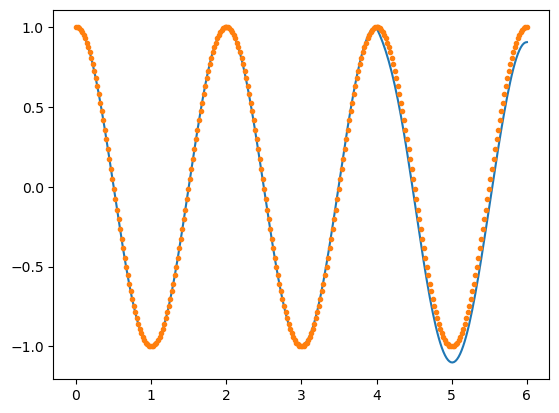

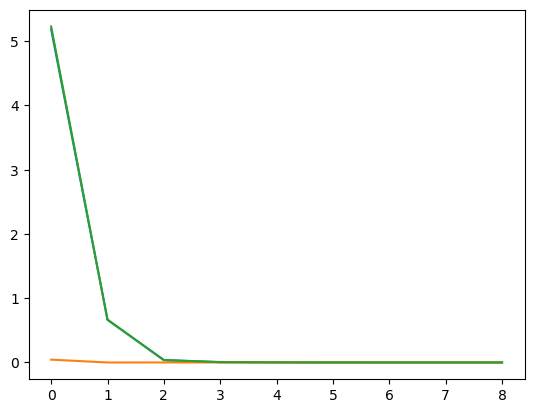

In [2]:

# EVAL:BEGIN
x_all = []
y_all = []
for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver_list[T_id].model_eval(x_cpu, use_best_model_flag = False)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])
# EVAL:END

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )
test_log = solver_list[1].get_logger()
test_log_np = np.array(test_log)

fig,ax = plt.subplots()
plt.plot(test_log_np[:,0])
plt.plot(test_log_np[:,1])
plt.plot(test_log_np[:,2])
print(test_log_np)

print(last_flame_data_list)